In [4]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import numpy as np
import warnings
import matplotlib as mpl

warnings.simplefilter(action="ignore", category=FutureWarning)

#Read in the data
df = pd.read_csv('Footballdata/Season/PrimeiraLiga.csv', encoding='latin-1', low_memory=False)

#Temporary because teams are getting combined together
df['name'] = df['name'].str.cat(df['teamId'], sep='_')

#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Change Offside Passes to Passes
df = df.replace('OffsidePass', 'Pass')

#remove
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Set passer and receiver
df['passer'] = df['name'].where(df['type_displayName'] == 'Pass', '')
df['receiver'] = df['name'].shift(-1).where(df['type_displayName'] == 'Pass', '')

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'CornerAwarded'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'OffsideGiven'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'SubstitutionOn'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'FormationChange'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Start'))]

#Previous end X and end Y
df['prev_endX'] = df['endX'].shift(1)
df['prev_endY'] = df['endY'].shift(1)

#Receive
df['zone14_Receive'] = np.where((df['type_displayName'].shift(1) == "Pass") & (df['outcomeType_displayName'].shift(1) == 'Successful') &
                               ((df['prev_endX'].between(80,99.6)) & (df['prev_endY'].between(29.44,50.56))),1,0)
zone14Receive_df = df.loc[(df['zone14_Receive']) == 1]

df['HS_Receive'] = np.where((df['type_displayName'].shift(1) == 'Pass') & (df['outcomeType_displayName'].shift(1) == 'Successful') & 
                          (((df['prev_endY'].between(16.88,29.44)) | (df['prev_endY'].between(50.56,63.12))) & (df['prev_endX'].between(80,120))),1,0)
HSReceive_df = df.loc[(df['HS_Receive']) == 1]

df['Wide_Receive'] = np.where((df['type_displayName'].shift(1) == "Pass") & (df['outcomeType_displayName'].shift(1) == 'Successful') &
                             ((df['prev_endY'].between(0,8.44)) | (df['prev_endY'].between(71.56,80))),1,0)
WideReceive_df = df.loc[(df['Wide_Receive']) == 1]

df['Central_Receive'] = np.where((df['type_displayName'].shift(1) == "Pass") & (df['outcomeType_displayName'].shift(1) == 'Successful') &
                                 ((df['prev_endY'].between(16.88, 63.12)) & (df['prev_endX'].between(20.4, 99.6))),1,0)
CentralReceive_df = df.loc[(df['Central_Receive']) == 1]

In [5]:
#List of Progressive Passes
zone14_list = zone14Receive_df.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Zone 14 Received'}).sort_values('name', ascending = True).reset_index()
del zone14_list['index']

halfspace_list = HSReceive_df.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Half Space Received'}).sort_values('name', ascending = True).reset_index()
del halfspace_list['index']

wide_list = WideReceive_df.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Wide Received'}).sort_values('name', ascending = True).reset_index()
del wide_list['index']

central_list = CentralReceive_df.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Central Received'}).sort_values('name', ascending = True).reset_index()
del central_list['index']


#Total List
receivelist = pd.merge(pd.merge(pd.merge(zone14_list, halfspace_list, how='outer'), wide_list, how='outer'), central_list, how='outer')
receivelist.fillna(0, inplace=True)
receivelist.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)
receivelist = receivelist.sort_values('Zone 14 Received', ascending= False).reset_index(drop = True)
receivelist.index += 1

receivelist["Zone 14 Received"] = receivelist["Zone 14 Received"].astype(int)
receivelist["Half Space Received"] = receivelist["Half Space Received"].astype(int)
receivelist["Wide Received"] = receivelist["Wide Received"].astype(int)
receivelist["Central Received"] = receivelist["Central Received"].astype(int)

receivelist['Player'] = receivelist['Player'].str.split('_').str[0]

receivelist = receivelist[['Player','Team','Zone 14 Received', 'Wide Received','Central Received',"Half Space Received"]]

receivelist.to_csv(r'C:\Users\user\Downloads\Poss\PL.csv', encoding='latin-1')
receivelist.head(10)

,Player,Team,Zone 14 Received,Wide Received,Central Received,Half Space Received
1,Pote,Sporting CP,97,242,598,179
2,Ricardo Horta,Braga,87,195,554,192
3,Iuri Medeiros,Braga,84,136,467,145
4,Rafa,Benfica,80,112,474,251
5,João Mário,Benfica,75,431,524,165
6,Fran Navarro,Gil Vicente,70,47,274,80
7,Mehdi Taremi,Porto,65,143,378,172
8,David Neres,Benfica,62,274,431,185
9,Otávio,Porto,62,255,676,120
10,Trincão,Sporting CP,62,219,427,135


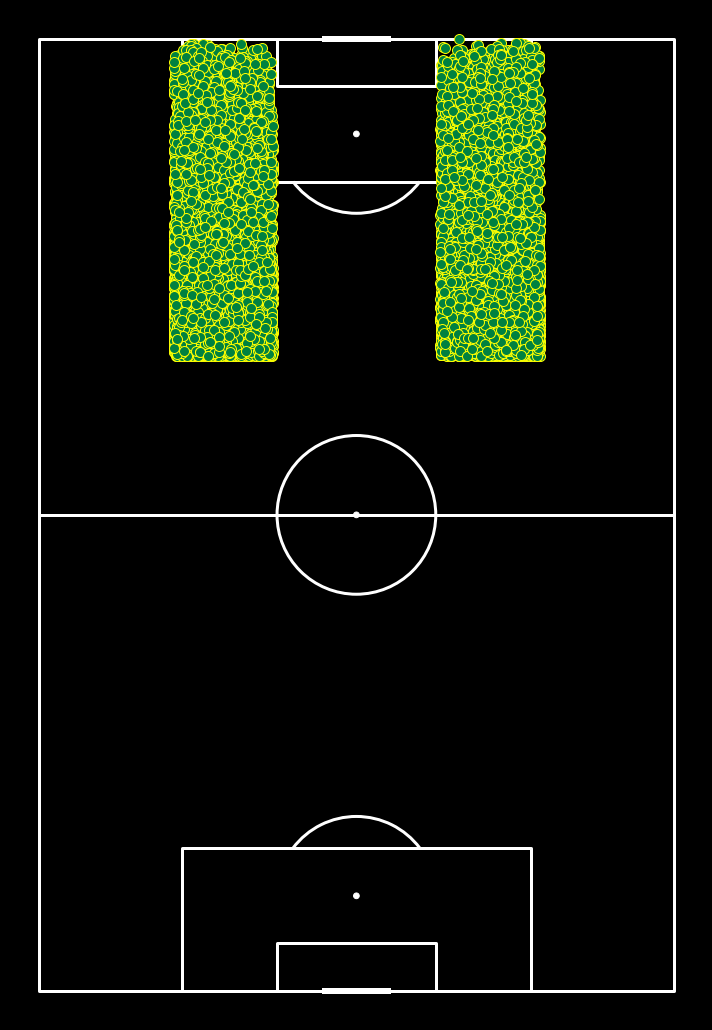

In [9]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',
                  line_zorder=-3, linewidth=3, spot_scale=0.003)

fig,ax = pitch.draw(figsize=(10, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Successful Passes (sdf1)
pitch.scatter(HSReceive_df.prev_endX, HSReceive_df.prev_endY, edgecolors= 'yellow', c='#008140',
              s = 100, zorder=4, ax=ax, marker = 'o', linewidth=1)

"""pitch.lines(WideReceive_df.x,WideReceive_df.y,WideReceive_df.endX,WideReceive_df.endY,
            ax=ax, color= '#00c631', lw=2, alpha = 0.9)
"""

plt.show()